[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/atmos-cloud-sim-uj/PySDM-examples.git/main?urlpath=PySDM_examples/Lowe_et_al_2019/fig_2.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atmos-cloud-sim-uj/PySDM-examples/blob/main/PySDM_examples/Lowe_et_al_2019/fig_2.ipynb)

#### based on Fig. 2 from Lowe et al. 2019 (Nature Comm.)  "_Key drivers of cloud response to surface-active organics_"   
https://doi.org/10.1038/s41467-019-12982-0

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install atmos-cloud-sim-uj-utils
    from atmos_cloud_sim_uj_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
from PySDM_examples.Lowe_et_al_2019 import Settings, Simulation
from PySDM_examples.Lowe_et_al_2019.aerosol import AerosolBoreal, AerosolMarine, AerosolNascent
from atmos_cloud_sim_uj_utils import show_plot
from PySDM.initialisation import spectral_sampling as spec_sampling
from PySDM.physics import si
import numpy as np
import matplotlib
from matplotlib import pylab

In [3]:
from PySDM.physics.surface_tension import compressed_film
compressed_film.sgm_org = 40 * si.mN / si.m
compressed_film.delta_min = 0.1 * si.nm  # TODO #604 0.2 in the paper, but 0.1 matches the paper plots

In [4]:
output = {}
for aerosol in (AerosolMarine(), AerosolBoreal(), AerosolNascent()):
    for model in ('bulk', 'film'):
        key = f"{aerosol.__class__.__name__}-{model}"
        print(key)
        settings = Settings(
            dt=1*si.s, n_sd_per_mode=1024, 
            model=model,
            aerosol=aerosol,
            spectral_sampling=spec_sampling.ConstantMultiplicity
        )
        settings.output_interval = 2 * si.s

        simulation = Simulation(settings)
        output[key] = simulation.run()
        output[key]['color'] = aerosol.color

AerosolMarine-bulk
AerosolMarine-film
AerosolBoreal-bulk
AerosolBoreal-film
AerosolNascent-bulk
AerosolNascent-film


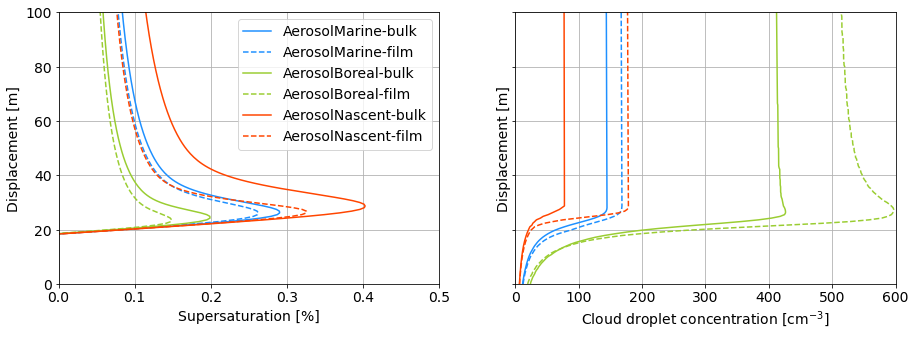

In [5]:
figsize = (15, 5)
pylab.rc('font', size=14)
fig, axs = pylab.subplots(1, 2, figsize=figsize, sharey=True)


for idx, var in enumerate(('S_max', 'n_c_cm3')):
    for key in output.keys():
        Y = np.asarray(output[key]['z'])
        axs[idx].plot(output[key][var], Y, label=key, 
                      color=output[key]['color'],
                      linestyle='-' if key.endswith('-bulk') else '--'
                     )
    axs[idx].set_ylim(0, 100)
    
    axs[idx].set_ylabel('Displacement [m]')
    if var == 'S_max':
        axs[idx].set_xlabel('Supersaturation [%]')
        axs[idx].set_xlim(0, 0.5)
    elif var == 'n_c_cm3':
        axs[idx].set_xlabel('Cloud droplet concentration [cm$^{-3}$]')
        axs[idx].set_xlim(0, 600)
    else:
        assert False
    
for ax in axs:
    ax.grid()
axs[0].legend()
pylab.savefig("fig2ab.png")
pylab.show()
#show_plot()

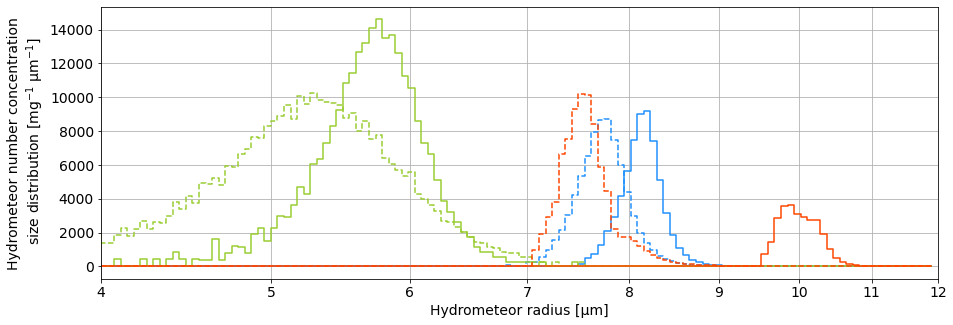

In [6]:
record_number = -1
figsize = (15, 5)
pylab.rc('font', size=14)
fig, axs = pylab.subplots(1, 1, figsize=figsize, sharey=True)
for key in output.keys():
    pylab.step(
        settings.wet_radius_bins_edges[:-1] / si.um,
        output[key]['spectrum'],
        label=f'wet ({key})',
        color=output[key]['color'],
        linestyle='-' if key.endswith('-bulk') else '--',
        where='pre'
    )
pylab.xscale('log')
pylab.grid()
pylab.xlabel("Hydrometeor radius [μm]")
pylab.ylabel("Hydrometeor number concentration\n size distribution [mg$^{-1}$ μm$^{-1}$]")
xticks = (4,5,6,7,8,9,10,11,12)
axs.set_xticks(xticks)
axs.set_xlim(xticks[0], xticks[-1])
axs.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
pylab.savefig("fig2c.png")
pylab.show()
#show_plot()